#Q-learning  Open AI Gym

$Q_{new}(s_t,a_t)=Q(s_t,a_t)+\alpha\cdot(r_t+\gamma\cdot max(Q(s_{t+1},a)))$<br><br>
$s_t$ - current state<br>
$a_t$ - current action<br>
$α$ - next action<br>
$r_t$ - current reward<br>
$\alpha$ - learning rate<br>
$\gamma$ - reward discout


**Frozen Lake 8x8 V0**

https://gym.openai.com/envs/FrozenLake8x8-v0/

SFFF       (S: starting point, safe)<br>
FHFH       (F: frozen surface, safe)<br>
FFFH       (H: hole, fall to your doom)<br>
HFFG       (G: goal, where the frisbee is located)<br>


#Q-NN

## Import the dependencies

In [ ]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os
from google.colab import drive
import time

##Create the environment

In [ ]:
environment = 'FrozenLake8x8-v0'
env = gym.make(environment)
state_space = env.observation_space.n
action_space = env.action_space.n

## Help functions

In [ ]:
def is_explore():
    global epsilon, epsilon_decay, epsilon_min
    epsilon = max(epsilon-epsilon_decay,epsilon_min)
    if np.random.rand() < epsilon:
        return True
    else:
        return False

In [ ]:
# One-hot encodes a state into a tensor
def one_hot_encoding( x, l):
  out_tensor = torch.zeros([1, l])
  out_tensor[0][x] = 1
  return out_tensor

## Train model

In [ ]:
#steps = 200

loss_history = []
reward_history = []
episodes = 10000 #40000
successes = 0

delay = 0 # 0.1

epsilon = .8
epsilon_min = .1
epsilon_decay = .01

gamma = .9
learning_rate = .2

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.state_space = env.observation_space.n
        self.action_space = env.action_space.n
        self.hidden = 1000
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy = Policy()
policy.to(device)

Policy(
  (l1): Linear(in_features=64, out_features=1000, bias=False)
  (l2): Linear(in_features=1000, out_features=4, bias=False)
)

In [20]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()
    done = False ##

    while not done: 

        # get first action value function
        Q = policy(Variable(one_hot_encoding(state, state_space)).to(device)) 
        
        # choose epsilon-greedy action
        if is_explore():
            action = env.action_space.sample()
        else:
            _, action = torch.max(Q, 1)
            action = action.item()
        
        # step forward and receive next state and reward
        next_state, reward, done, _ = env.step(action)   

        
        # find max Q for t+1 state
        Q1 = policy(Variable(one_hot_encoding(next_state, state_space)).to(device))
        maxQ1, _ = torch.max(Q1, 1)
        
        # create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[0,action] = reward + torch.mul(maxQ1.detach(), gamma) 
        
        # calculate loss
        loss = loss_fn(Q, Q_target)
        
        # update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        if done and reward == 0.0: reward = -1
        episode_reward += reward
        #env.render()
        if done:
            if reward == 1:
                # adjust learning rate
                scheduler.step()
                successes += 1            
            loss_history.append(episode_loss)
            reward_history.append(episode_reward) 
            break
        else:
            state = next_state 
            
print('\n successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))


100%|██████████| 10000/10000 [12:41<00:00, 13.13it/s]


 successful episodes: 27 - 0.2700%


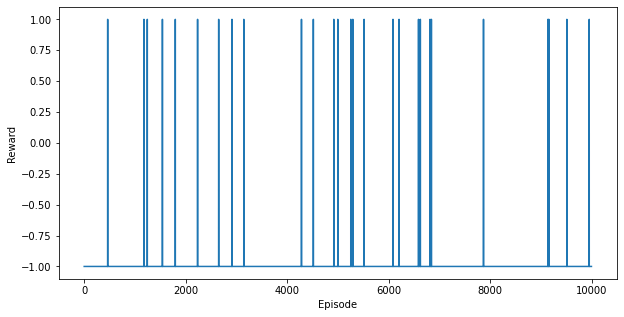

In [21]:
plt.figure(2, figsize=[10,5])
r = pd.Series(reward_history)
plt.plot(r)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

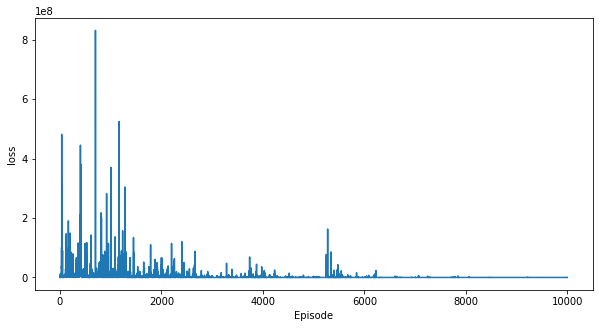

In [22]:
plt.figure(2, figsize=[10,5])
r = pd.Series(loss_history)
plt.plot(r)
plt.xlabel('Episode')
plt.ylabel('loss')
plt.show()

Text(0.5, 0, 'Episode')

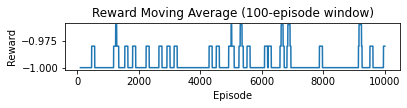

In [23]:
window = int(episodes/100)
plt.subplot(412)
plt.plot(pd.Series(reward_history).rolling(window).mean())
plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.ylabel('Reward')
plt.xlabel('Episode')

Text(0.5, 0, 'Episode')

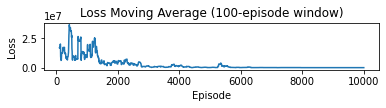

In [24]:
plt.subplot(413)
plt.plot(pd.Series(loss_history).rolling(window).mean())
plt.title('Loss Moving Average ({}-episode window)'.format(window))
plt.ylabel('Loss')
plt.xlabel('Episode')

## Test for 1 example

In [25]:
state = env.reset()
reward = 0
done = False
policy.eval()
wins = 0
i = 0
    
while not done:
        i += 1
        maxQ1, action = torch.max(policy(Variable(one_hot_encoding(state, state_space)).to(device)), 1)
        next_state, reward, done, _ = env.step(action.item())
        #clear()
        #clear_output() #hd
        #print('state', state)
        #print('next_state', next_state)
        env.render()
        #learn(state, action, reward, next_state)
        state = next_state #hd
        #print(q_table) # hd
        #print('state', state)
        if done:
            env.render()
            print('number of steps:', i)
            if reward > 0:
                wins += 1
                print ('------goal')
            else:
                print ('-----hole')
            time.sleep(3*delay)
        else:            
            time.sleep(delay)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF


## Test for 100 examples

In [26]:
policy.eval()
wins = 0
env.reset()
test_episodes = 100

for episode in range(test_episodes): 
    print('episode: ', episode)      
    state = env.reset()
    reward = 0
    done = False
    i = 0

    while not done:
        i += 1
        maxQ1, action = torch.max(policy(Variable(one_hot_encoding(state, state_space)).to(device)), 1)
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        if done:
            env.render()
            print('number of steps:', i)
            if reward > 0:
                wins += 1
                print ('------goal')
            else:
                print ('-----hole')
            time.sleep(3*delay)
        else:            
            time.sleep(delay)

print("Goals/Holes: %d/%d" % (wins, test_episodes - wins))
env.close() 

episode:  0
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 9
-----hole
episode:  1
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 7
-----hole
episode:  2
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 19
-----hole
episode:  3
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 15
-----hole
episode:  4
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 10
-----hole
episode:  5
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 7
-----hole
episode:  6
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 10
-----hole
episode:  7
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
number of steps: 11
-----hole
episode:  8
  (Down)
SFFFFFFF


## Save the model

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Specify a path
path = "/content/gdrive/MyDrive/FrozenLake8x8/state_dict_model.pt"

# Save
torch.save(policy.state_dict(), path)